In [1]:
#NN Surrogate model class
import injector_surrogate_quads
from injector_surrogate_quads import *
import physics_gp
import os

sys.path.append('../configs')
#Sim reference point to optimize around
from ref_config import ref_point

#Pytorch 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gpytorch
import botorch 

random_seed = 1
torch.manual_seed(random_seed)

# BO with Expressive Priors
### BO Minimizes Emittance*Bmag with 9 Variables (SQ, CQ, SOL, matching quads)

In [2]:
# load injector model
Model = Surrogate_NN()

Model.load_saved_model(model_path = '../models/', \
                       model_name = 'model_OTR2_NA_rms_emit_elu_2021-07-27T19_54_57-07_00')
Model.load_scaling()
Model.take_log_out = False

2022-06-23 14:45:54.034456: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# design Twiss parameters 
beamline_info = json.load(open('../configs/beamline_info.json'))
get_twiss0 = beamline_info['Twiss0']

# emit, beta, alpha
twiss0 = {'x': [get_twiss0[0], get_twiss0[2], get_twiss0[4]],
          'y': [get_twiss0[1], get_twiss0[3], get_twiss0[5]]}

beta0_x, alpha0_x = twiss0['x'][1], twiss0['x'][2]
beta0_y, alpha0_y = twiss0['y'][1], twiss0['y'][2]
# print(twiss0['x'])
# print(twiss0['y'])

## Objective Function

In [4]:
# convert to machine units
ref_point = Model.sim_to_machine(np.asarray(ref_point))

# input params: solenoid and quads to vary 
opt_var_names = ['SOL1:solenoid_field_scale','CQ01:b1_gradient', 'SQ01:b1_gradient',
                 "QA01:b1_gradient", "QA02:b1_gradient", 
                 "QE01:b1_gradient", "QE02:b1_gradient", "QE03:b1_gradient", "QE04:b1_gradient"]
bounds = torch.as_tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
                       [-4, -1], [1, 4],
                       [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

# output params: emittance in transverse plane (x & y)
opt_out_names = ['norm_emit_x','norm_emit_y']

def evaluate(config): 
    """
    D is input space dimensionality
    :param config: input values of opt_var_names, torch.tensor, shape (1, D) 
    """
    #make input array of length model_in_list (inputs model takes)
    x_in = np.empty((1,len(Model.model_in_list)))

    #fill in reference point around which to optimize
    x_in[:,:] = np.asarray(ref_point[0])

    #set solenoid, CQ, SQ, matching quads to values from optimization step
    for i in range(config.size(dim=0)):
        x_in[:, Model.loc_in[opt_var_names[i]]] = config[i]

    #output predictions
    y_out = Model.pred_machine_units(x_in) 

    return -1*objective(y_out)[0]


def objective(y_out):
    # output is emittance * bmag 
    
    # geometric emittance in transverse plane
    out1 = y_out[:, Model.loc_out['norm_emit_x']] #grab norm_emit_x out of the model
    out2 = y_out[:, Model.loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    emit = np.sqrt(out1 * out2)
  
    sigma_x = y_out[:, Model.loc_out['sigma_x']] #grab sigma_x out of the model 
    sigma_y = y_out[:, Model.loc_out['sigma_y']] #grab sigma_y out of the model 
    
    # real beta and alpha 
    # NEEDS TO BE FIXED - currently assuming real alpha to be the same as design alpha 
    alpha_x, alpha_y = alpha0_x, alpha0_y
    beta_x, beta_y = (sigma_x**2) / out1, (sigma_y**2) / out2
    
    # bmag 
    bmag_x = 0.5 * ((beta0_x / beta_x) + (beta_x / beta0_x)) + 0.5 * ((alpha_x * np.sqrt(beta0_x / beta_x) - alpha0_x * np.sqrt(beta_x / beta0_x))**2)
    bmag_y = 0.5 * ((beta0_y / beta_y) + (beta_y / beta0_y)) + 0.5 * ((alpha_y * np.sqrt(beta0_y / beta_y) - alpha0_y * np.sqrt(beta_y / beta0_y))**2)
    bmag = np.sqrt(bmag_x * bmag_y)
    #print(f'bmag: {bmag} emit: {emit}') 
    
    return (emit * bmag)/1e-6 # in um units 
    #return np.sqrt(out1*out2)/1e-6 # in um units

In [5]:
# mesh grid of 3^9 points to sample
n_samples_per_var = 3
n_var = 9

"""
create x and y if they are not saved in grid.pt, otherwise load x and y the next section 
"""
# create input and output data
if os.path.exists('./results/grid.pt') and os.stat('./results/grid.pt').st_size > 0: 
    training_dict = torch.load('grid.pt')
    x = training_dict['x']
    y = training_dict['y']
else: 
    var_points = torch.zeros((n_var, n_samples_per_var)) 
    # take n_samples_per_var points from each dimension i
    for i in range(n_var):
        var_points[i,:] = torch.linspace(bounds[i,0],bounds[i,1],n_samples_per_var)

    # generate grid of points to sample 
    grid = np.array(np.meshgrid(*var_points)).reshape(n_var,-1)
    x = torch.zeros((n_samples_per_var**n_var, n_var))
    for i in range(n_samples_per_var**n_var):
        x[i:] = torch.as_tensor(grid[:,i])
    y = torch.as_tensor([evaluate(ele) for ele in x])
    torch.save({'x': x, 'y': y}, 'grid.pt')

print(x)
print(x.shape)
print(y.reshape(-1,1))

tensor([[ 0.4600, -0.0200, -0.0200,  ..., -1.0000, -1.0000, -7.0000],
        [ 0.4600, -0.0200, -0.0200,  ..., -1.0000, -1.0000, -3.0000],
        [ 0.4600, -0.0200, -0.0200,  ..., -1.0000, -1.0000,  1.0000],
        ...,
        [ 0.4850,  0.0200,  0.0200,  ...,  7.0000,  7.0000, -7.0000],
        [ 0.4850,  0.0200,  0.0200,  ...,  7.0000,  7.0000, -3.0000],
        [ 0.4850,  0.0200,  0.0200,  ...,  7.0000,  7.0000,  1.0000]])
torch.Size([19683, 9])
tensor([[ -6.9780],
        [-10.3164],
        [ -5.1626],
        ...,
        [ -4.3536],
        [ -6.9199],
        [ -7.3886]], dtype=torch.float64)


## Fit data with second order polynomial

In [ ]:
# f(x) = x^T A x + B x + C
# x is a 9x1 column vector, A is a symmetric 9x9 matrix, B is a 1x9 vector, C is a scalar.
a_vals = torch.randn((int(n_var*(n_var+1)/2),1)).reshape(1,-1)
A = torch.zeros(n_var, n_var)
i, j = torch.triu_indices(n_var, n_var)
A[i, j] = a_vals
A.T[i, j] = a_vals
A = A.clone().detach().requires_grad_(True)
print(A)

B = torch.randn((1, n_var), requires_grad=True)
#print(B) 

C = torch.randn((1,1), requires_grad = True)
#print(C)

learning_rate = 1e-4
for i in range(2000):
    # if (i > 30 and i % 10 == 0 and learning_rate >= 1e-7):
    #     learning_rate /= 10
    y_pred = torch.cat([torch.matmul(ele, torch.matmul(A, ele.T)) + torch.matmul(B, ele.T) + C for ele in x]).reshape(1,-1)[0]

    loss = (y_pred - y).pow(2).mean() #
    if (i % 50 == 0):
        print(i, loss.item())
        print(y_pred)
    #print(loss.item())
    loss.backward()

    with torch.no_grad():
        A -= learning_rate * A.grad
        B -= learning_rate * B.grad
        C -= learning_rate * C.grad

        # Manually zero the gradients after updating weights
        A.grad = None
        B.grad = None
        C.grad = None

print(f'Result: y = x{A}X^T + {B} x + {C.item()}')
torch.save({'x': x, 'y': y, 'A': A, 'B': B, 'C': C, 'y_pred': y_pred}, 'grid.pt')

## Fit data with a Neural Network

In [35]:
batch_size = 512

transformer_x = botorch.models.transforms.input.Normalize(n_var, bounds = bounds.transpose(0,1))
normed_x = F.normalize(x, dim = 0) 
print(normed_x)  
#train_data = torch.utils.data.TensorDataset(x.float(), y.reshape(-1,1).float())
train_data = torch.utils.data.TensorDataset(normed_x.float(), y.reshape(-1,1).float())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

tensor([[ 0.0069, -0.0087, -0.0087,  ..., -0.0016, -0.0016, -0.0113],
        [ 0.0069, -0.0087, -0.0087,  ..., -0.0016, -0.0016, -0.0048],
        [ 0.0069, -0.0087, -0.0087,  ..., -0.0016, -0.0016,  0.0016],
        ...,
        [ 0.0073,  0.0087,  0.0087,  ...,  0.0113,  0.0113, -0.0113],
        [ 0.0073,  0.0087,  0.0087,  ...,  0.0113,  0.0113, -0.0048],
        [ 0.0073,  0.0087,  0.0087,  ...,  0.0113,  0.0113,  0.0016]])
torch.Size([512, 9])
torch.Size([512, 1])


In [36]:
# model 
class NN_prior(nn.Module):
    def __init__(self):
        super(NN_prior, self).__init__()
        
        hidden_size = 10
        self.linear1 = nn.Linear(n_var, hidden_size)
        self.tan1 = nn.Tanh()
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.tan2 = nn.Tanh()
        self.linear3 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.tan1(x)
        x = self.linear2(x)
        x = self.tan2(x)
        x = self.linear3(x)
        return x 

In [37]:
log_interval = 50
def train_model(model, epochs, train_loader, optimizer):
    train_losses = []
    
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad() 
            output = model(data) 
            
            loss = F.mse_loss(output, target) 
            loss.backward()
            
            optimizer.step() 
            
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            torch.save(model.state_dict(), './results/model_1.pth') 
            torch.save(optimizer.state_dict(), './results/optimizer.pth')
    return train_losses

In [38]:
NN_prior_model = NN_prior()
NN_optimizer = optim.SGD(NN_prior_model.parameters(), lr = 0.001, momentum = 0.5)
n_epochs = 200
train_losses = train_model(NN_prior_model, n_epochs, train_loader, NN_optimizer)

Train Epoch: 0 [0/19683 (0%)]	Loss: 88.210503
Train Epoch: 1 [0/19683 (0%)]	Loss: 46.673450
Train Epoch: 2 [0/19683 (0%)]	Loss: 93.189499
Train Epoch: 3 [0/19683 (0%)]	Loss: 30.950060
Train Epoch: 4 [0/19683 (0%)]	Loss: 27.132442
Train Epoch: 5 [0/19683 (0%)]	Loss: 72.461189
Train Epoch: 6 [0/19683 (0%)]	Loss: 14.470196
Train Epoch: 7 [0/19683 (0%)]	Loss: 284.997498
Train Epoch: 8 [0/19683 (0%)]	Loss: 6873.981934
Train Epoch: 9 [0/19683 (0%)]	Loss: 122.010201
Train Epoch: 10 [0/19683 (0%)]	Loss: 27.604368
Train Epoch: 11 [0/19683 (0%)]	Loss: 52.272797
Train Epoch: 12 [0/19683 (0%)]	Loss: 2493.732666
Train Epoch: 13 [0/19683 (0%)]	Loss: 16.914001
Train Epoch: 14 [0/19683 (0%)]	Loss: 102.432465
Train Epoch: 15 [0/19683 (0%)]	Loss: 25.215687
Train Epoch: 16 [0/19683 (0%)]	Loss: 30.545605
Train Epoch: 17 [0/19683 (0%)]	Loss: 211.950821
Train Epoch: 18 [0/19683 (0%)]	Loss: 37.970100
Train Epoch: 19 [0/19683 (0%)]	Loss: 27.693855
Train Epoch: 20 [0/19683 (0%)]	Loss: 104.564972
Train Epoch: 2

## Scan

In [39]:
# models  
training_dict = torch.load('grid.pt')
x = training_dict['x']
y = training_dict['y']
A = training_dict['A']
B = training_dict['B'] 
C = training_dict['C'] 
y_pred = training_dict['y_pred']

def polynomial_model(x):
    """
    :param x: input values, tensor, shape (num_samples, num_var) 
    returns y_pred as tensor, shape (1, num_samples) 
    """ 
    return torch.cat([torch.matmul(ele, torch.matmul(A, ele.T)) + torch.matmul(B, ele.T) + C for ele in x.float()]).reshape(1,-1)[0]

NN_model = NN_prior()
NN_model.load_state_dict(torch.load('./results/model_1.pth'))
NN_model.eval()

print(NN_model(normed_x[0]))
#best = NN_y_100epochs_4hidden_tanh

tensor([-5.4188], grad_fn=<AddBackward0>)


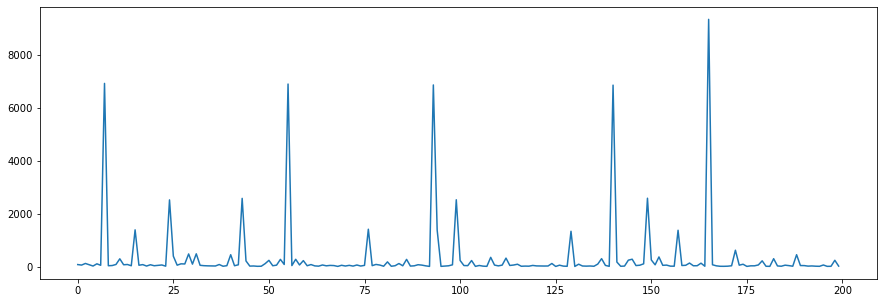

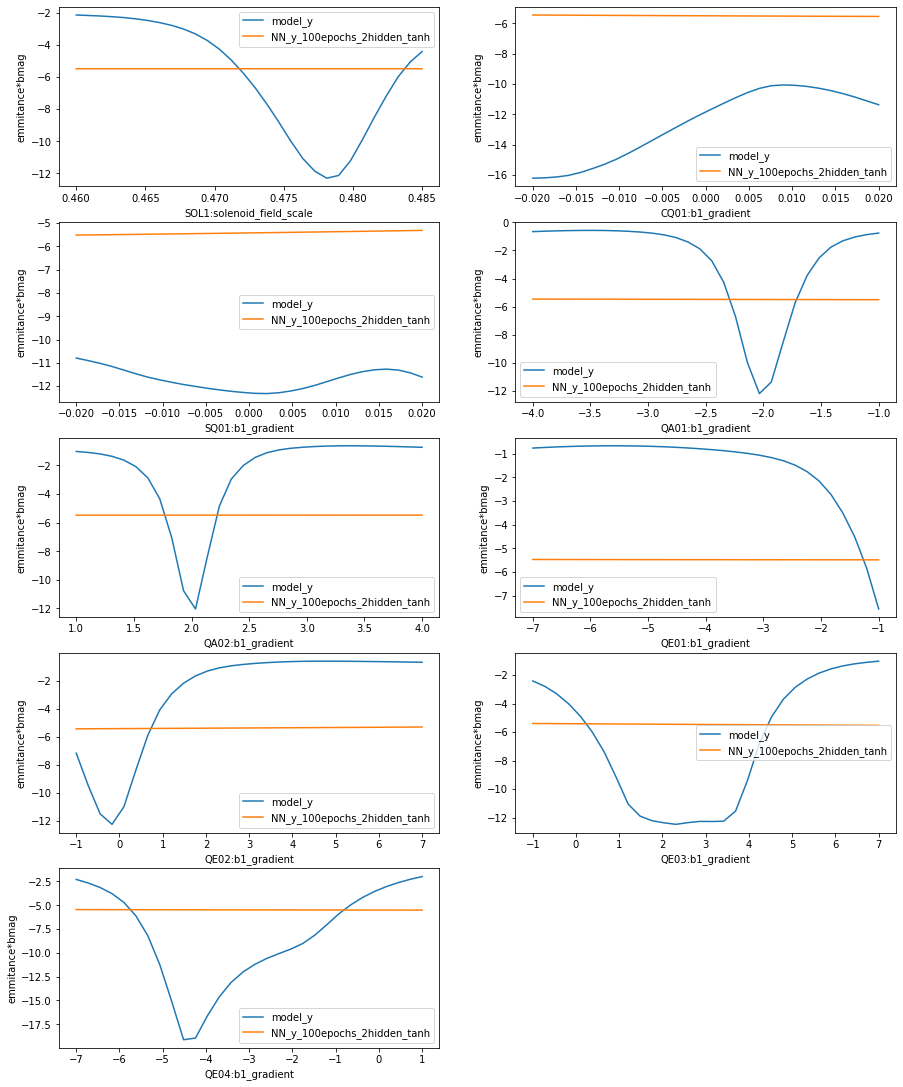

In [50]:
import matplotlib.pyplot as plt
# scanning function 
# use ref point values for the parameters that are kept constant 
scan_ref_point = torch.cat([torch.as_tensor([ref_point[0][Model.loc_in[param_name]]]) for param_name in opt_var_names])
#print(scan_ref_point) 

plt.rcParams["figure.figsize"] = (15,5)
# plot loss
i = torch.arange(200)
plt.plot(i, train_losses[:200])
plt.show()
 
def scan(model_param, num_scans, model_prior):
    """
    scans values across a single parameter of the model, keeping others constant
    :param model_param: name of the model param that is being scanned, string, size 1 
    :param num_scans: number of values scanned for parameter 
    returns model_test_y, polynomial_test_y of all scanned values  
    """ 
    param_index = opt_var_names.index(model_param)
    test_x = scan_ref_point.repeat(num_scans, 1) 
    test_x[:,param_index] = torch.linspace(bounds[param_index, 0], bounds[param_index, 1], num_scans)
    #print(test_x)
    
    model_test_y = torch.as_tensor([evaluate(ele) for ele in test_x])
    #prior_test_y = model_prior(test_x.float()) 
    prior_test_y = model_prior(F.normalize(test_x, dim = 0).float()) 
    return model_test_y, prior_test_y, test_x

plt.rcParams["figure.figsize"] = (15,35)
for i in range(len(opt_var_names)):
    model_param = opt_var_names[i] 
    model_test_y, prior_test_y, test_x = scan(model_param, 30, NN_model) 
    plt.subplot(9, 2, i+1)
    plt.xlabel(model_param)
    plt.ylabel('emmitance*bmag')
    plt.plot(test_x[:,opt_var_names.index(model_param)], model_test_y, label = "model_y")
    plt.plot(test_x[:,opt_var_names.index(model_param)], prior_test_y.detach(), label = "NN_y_100epochs_2hidden_tanh")
    plt.legend()
    
plt.show()
